# setting up 

In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
import glob

import tarfile
import zipfile
import copy
import pandas as pd
import seaborn as sns
import datetime

from FaceDetectorOpenCV import *

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import load_img, img_to_array

from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Conv2D, Activation, MaxPool2D, Flatten, Dropout, MaxPooling2D,BatchNormalization,GlobalAveragePooling2D
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint,TensorBoard,EarlyStopping
from keras.optimizers import RMSprop, Adam, Adagrad

from sklearn.metrics import confusion_matrix
import itertools

working_dir = 'D:/Mandy/emotion-recognition-transferlearning/'

Using TensorFlow backend.


In [2]:
#runs the model specified
#train data follos format [x, y].  Same with val_data
def run_model(model, model_name, epochs, train_data, val_data, batch_size,monitor_index):
    # save best weights
    log_dir="logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    
    checkpointer = ModelCheckpoint(filepath=working_dir + 'checkpoints/' + '%s.h5'%model_name, monitor=monitor_index, verbose=1,save_best_only=True, mode='auto', period=1)
    
    # stop if the model does not improve for 15 epoches
    stoppointer = EarlyStopping(monitor=monitor_index, min_delta=0, patience=15, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

    # run model
    history = model.fit(train_data[0], train_data[1], epochs=epochs,
                   shuffle=True,
                   batch_size=batch_size, validation_data=(val_data[0], val_data[1]),
                   callbacks=[checkpointer,stoppointer], verbose=2)
    return history

#saves model to json file saves model weights to h5 file
def save_model(model, model_name, working_dir):

    # save model to json
    model_json = model.to_json()
    with open(working_dir + 'models/' + "%s.json"%model_name, "w") as json_file:
        json_file.write(model_json)

    #save model weights
    model.save_weights(working_dir +'models/' + '%s_weights.h5'%model_name)

# draw the training curves
def draw_graphs(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,max(plt.ylim())])
    plt.title('Training and Validation Loss')
    plt.show()

# load a trained model
class Model:
    def __init__(self, model_info_path, model_name,weight_name):
        self.model = self.load_model(model_info_path + model_name)
        self.model = self.load_weights(self.model, model_info_path + weight_name)

    def load_model(self, path, json=True):
    #load model
        if json == False:
            print ('havent gotten that far yet')
        else:
            print (path)
            with open (path, 'r') as f:
                model = model_from_json(f.read())
            return model

    def load_weights (self, model, path, h5 = True):
        #loads weights
        if h5 == False:
            print ('havent gotten that far yet')
        else:
            model.load_weights(path)
            return model   

# convert a grey-scale image to 3-channel RGB
def to_rgb(image, input_shape):
    resized_image = cv2.resize(image, (input_shape[0],input_shape[1]), interpolation=cv2.INTER_CUBIC)
    img_rgb = np.stack((resized_image,)*3, axis=-1)
    return img_rgb

# plot confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# adding bounding box to the test image
def add_bounding_box_text(image,faces_coord,identified_category):
    for (x, y, w, h) in faces_coord:
        gray_fr = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        fc = gray_fr[y:y+h, x:x+w]
        cv2.rectangle(image,(x,y),(x+w,y+h),(255,0,0),4)
        cv2.putText(image, identified_category, (x, y),  cv2.FONT_HERSHEY_SIMPLEX,2, (255, 255, 0), 4)
    return image


def plot_single_image_prediction(image, detector, resized_shape, model,emotion_dict):
    grid = plt.GridSpec(1, 3, wspace=0.4, hspace=0.3)

    faces_coord = detector.detect(image, True)
    faces = normalize_faces(image ,faces_coord,resized_shape,0)
    cropped_faces = np.zeros((len(faces),resized_shape[0],resized_shape[1],3))
    for face_id, face in enumerate(faces):
        cropped_faces[face_id, :,:,: ] = face
    cropped_faces = cropped_faces.astype(int)

    predictions = model.predict(cropped_faces)
    predicted_category = emotion_dict[np.argmax(predictions)]
    image = add_bounding_box_text(image,faces_coord,predicted_category)

    plt.figure(figsize = (20, 6))
    plt.subplot(grid[0, 0])
    plt.imshow(test_image)
    plt.subplot(grid[0, 1:])
    plt.bar(emotion_dict.values(), predictions[0])
    plt.show()

def load_test_image(file_path, resized_length):
    image = np.array(Image.open(file_path))
    input_shape = image.shape
    factor = input_shape[0]/resized_length
    image = cv2.resize(image, (np.int(input_shape[1]/factor),np.int(input_shape[0]/factor)), interpolation=cv2.INTER_CUBIC)    
    return image

# load FER training data 

In [4]:
#extract the tar file
tar_dir = tarfile.open(working_dir + 'data/fer2013.tar.gz', 'r:gz')
tar_dir.extractall(working_dir+ 'data/')

#dataset from kaggle challege read into a pandas dataframe
images_df = pd.read_csv(working_dir + 'data/fer2013/fer2013.csv')

#make a emotion dict that relates the emotion number with the expression
emotion_dict = {0: 'Angry', 1:'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6:'Neutral'}
#see some descriptive statistics
images_df['emotion'].value_counts().rename(emotion_dict)

Happy       8989
Neutral     6198
Sad         6077
Fear        5121
Angry       4953
Surprise    4002
Disgust      547
Name: emotion, dtype: int64

In [5]:
#Setting up the training data
train_df = images_df[images_df['Usage'] == 'Training'][['emotion', 'pixels']]
train_df['pixels'] = train_df['pixels'].apply(lambda im: np.fromstring(im, sep=' '))

#df without 0s
index_0s = [i for i, x in enumerate(train_df['pixels']) if np.sum(x) == 0]
train_df = train_df[~train_df.index.isin(index_0s)].reset_index(drop = True)

x_train = np.vstack(train_df['pixels'].values)
y_train = np.array(train_df['emotion'])
print ('x_train shape is: ', x_train.shape)
print ('y_train shape is: ', y_train.shape)

x_train shape is:  (28698, 2304)
y_train shape is:  (28698,)


In [6]:
#Setting up the public test data
public_test_df = images_df[images_df['Usage'] == 'PublicTest'][['emotion', 'pixels']]
public_test_df["pixels"] = public_test_df["pixels"].apply(lambda im: np.fromstring(im, sep=' '))
x_public_test = np.vstack(public_test_df['pixels'].values)
y_public_test = np.array(public_test_df['emotion'])
print('x_public_test shape is: ', x_public_test.shape)
print('y_public_test shape is: ', y_public_test.shape)

x_public_test shape is:  (3589, 2304)
y_public_test shape is:  (3589,)


In [7]:
#resahpe images to a 48 x 48 pixel matrix
#we need to flatten it to one channel though which is what the 1 at the 
#end does
x_train = x_train.reshape(-1, 48, 48, 1)
x_public_test = x_public_test.reshape(-1, 48, 48, 1)
print ('x_train new shape is: ', x_train.shape)
print ('x_test new shape is: ', x_public_test.shape)

x_train new shape is:  (28698, 48, 48, 1)
x_test new shape is:  (3589, 48, 48, 1)


In [8]:
# upscale the images to 224x224 for transfer learning.
input_shape = [224,224];
x_train_resized = np.zeros((x_train.shape[0],input_shape[0],input_shape[1],3))
x_public_test_resized = np.zeros((x_public_test.shape[0],input_shape[0],input_shape[1],3))
for image_id in np.arange(x_train.shape[0]):
    x_train_resized[image_id,:,:,:] = to_rgb(x_train[image_id,:,:,0],input_shape)
for image_id in np.arange(x_public_test.shape[0]):
    x_public_test_resized[image_id,:,:,:] = to_rgb(x_public_test[image_id,:,:,0],input_shape)
print ('x_train new shape is: ', x_train_resized.shape)
print ('x_test new shape is: ', x_public_test_resized.shape)

x_train new shape is:  (28698, 224, 224, 3)
x_test new shape is:  (3589, 224, 224, 3)


In [9]:
#Make y categorical
y_train_cat= pd.get_dummies(y_train).as_matrix()
y_public_test_cat = pd.get_dummies(y_public_test).as_matrix()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


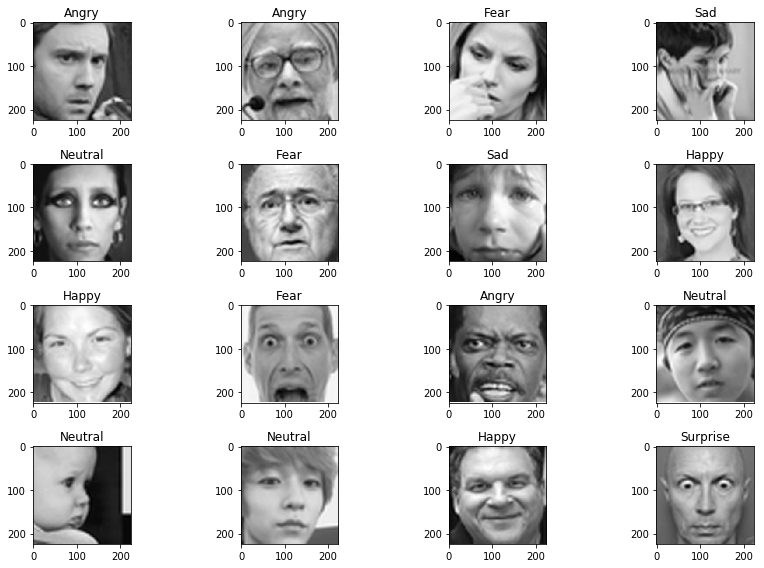

In [10]:
#show some images
plt.figure(0, figsize = (12, 8))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_train_resized[i, :, :, 0], cmap='gray')
    plt.title(emotion_dict[np.where(y_train_cat[i] == 1)[0][0]])
plt.tight_layout()
plt.show()

# load new training data

##### trying to see if adding more high resolution training images will help. The new dataset is made by combining part of the AffectNet, all FER and all RAF-DB images. There are ~80k training images in total

In [ ]:
new_data_dir = 'D:/Mandy/Faces_datasets/processed_collapsed_dataset_224x224x3/'

resized_shape = (224,224)
batch_size = 100

emotion_dict = {0: 'angry', 1:'disgust', 2: 'fear', 3: 'happy', 4: 'sad', 5: 'surprise', 6:'neutral'}
emotion_dict_reverse = dict((v,k) for k,v in emotion_dict.items())
category_list = emotion_dict.values()

# read training images as arrays
train_array = []
train_label_array = []
for category_name in category_list:
    print(category_name)
    train_paths = sorted(glob.glob(os.path.join(new_data_dir,'train',category_name,'*')))
    for file_path in train_paths:
        train_array.append(np.array(Image.open(file_path)))
        train_label_array.append(emotion_dict_reverse[category_name])

# read validation images as arrays
valid_array = []
valid_label_array = []
for category_name in category_list:
    print(category_name)
    train_paths = sorted(glob.glob(os.path.join(new_data_dir,'valid',category_name,'*')))
    for file_path in train_paths:
        valid_array.append(np.array(Image.open(file_path)))
        valid_label_array.append(emotion_dict_reverse[category_name])

# transform the arrays loaded
valid_new_x =  np.asarray(valid_array).reshape(-1,224,224,3)
train_new_x = np.asarray(train_array).reshape(-1,224,224,3)

valid_new_y =  pd.get_dummies(valid_label_array).as_matrix()
train_new_y =  pd.get_dummies(train_label_array).as_matrix()

# set up transfer learning with fine tuning

In [59]:
from keras_vggface.vggface import VGGFace
vggface = VGGFace(model='resnet50', include_top=False, input_shape = (224,224,3))

vggface.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(vggface.layers))

Number of layers in the base model:  174


In [60]:
# Fine tune from this layer onwards
fine_tune_at = 140

# Freeze all the layers before the `fine_tune_at` layer
for layer in vggface.layers[:fine_tune_at]:
    layer.trainable =  False

In [61]:
# add a few layers on top
model = Sequential([
    vggface, 
    Flatten(),
    Dropout(0.5),
    BatchNormalization(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(len(emotion_dict), activation='softmax', name = 'classifer')])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vggface_resnet50 (Model)     (None, 1, 1, 2048)        23561152  
_________________________________________________________________
flatten_20 (Flatten)         (None, 2048)              0         
_________________________________________________________________
dropout_38 (Dropout)         (None, 2048)              0         
_________________________________________________________________
batch_normalization_58 (Batc (None, 2048)              8192      
_________________________________________________________________
dense_30 (Dense)             (None, 128)               262272    
_________________________________________________________________
dropout_39 (Dropout)         (None, 128)               0         
_________________________________________________________________
batch_normalization_59 (Batc (None, 128)               512       
__________

Train on 28698 samples, validate on 3589 samples
Epoch 1/50
 - 90s - loss: 1.1403 - acc: 0.5936 - val_loss: 1.5070 - val_acc: 0.5419

Epoch 00001: val_loss improved from inf to 1.50704, saving model to D:/Mandy/emotion-recognition-transferlearning/checkpoints/vggFace_finetune_val_loss.h5
Epoch 2/50
 - 75s - loss: 0.9186 - acc: 0.6664 - val_loss: 1.7463 - val_acc: 0.4436

Epoch 00002: val_loss did not improve from 1.50704
Epoch 3/50
 - 75s - loss: 0.8180 - acc: 0.7035 - val_loss: 1.2839 - val_acc: 0.5592

Epoch 00003: val_loss improved from 1.50704 to 1.28389, saving model to D:/Mandy/emotion-recognition-transferlearning/checkpoints/vggFace_finetune_val_loss.h5
Epoch 4/50
 - 75s - loss: 0.7314 - acc: 0.7378 - val_loss: 1.1995 - val_acc: 0.5795

Epoch 00004: val_loss improved from 1.28389 to 1.19950, saving model to D:/Mandy/emotion-recognition-transferlearning/checkpoints/vggFace_finetune_val_loss.h5
Epoch 5/50
 - 75s - loss: 0.6355 - acc: 0.7749 - val_loss: 1.1056 - val_acc: 0.6308

Ep

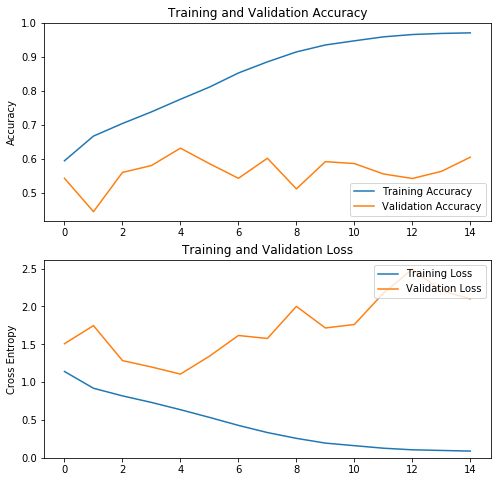

In [62]:
model.compile(optimizer = Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# # #run and train model
monitor_index = 'val_loss'
model_name = 'vggFace_finetune_'+ monitor_index

history = run_model(model, model_name, 50, [x_train_resized, y_train_cat], [x_public_test_resized, y_public_test_cat], 100, monitor_index)
save_model(model,model_name, working_dir)
draw_graphs(history)


In [ ]:
# run and train model on new data
monitor_index = 'val_loss'
model_name = 'newData_vggFace_finetune_'+ monitor_index

history = run_model(model, model_name, 50, [train_new_x, train_new_y], [valid_new_x, valid_new_y], 100, monitor_index)
save_model(model,model_name, working_dir)
draw_graphs(history)


## training a CNN from scratch (does not get better than transfer learning)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 44, 44, 32)        832       
_________________________________________________________________
activation_241 (Activation)  (None, 44, 44, 32)        0         
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 22, 22, 32)        0         
_________________________________________________________________
batch_normalization_68 (Batc (None, 22, 22, 32)        128       
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 18, 18, 64)        51264     
_________________________________________________________________
activation_242 (Activation)  (None, 18, 18, 64)        0         
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 9, 9, 64)          0         
__________

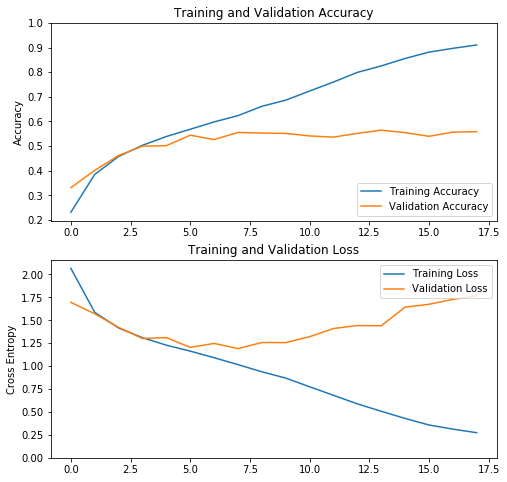

In [65]:
np.random.seed(1000)

# (3) Create a sequential model
model = Sequential()

# 1st Convolutional Layer
model.add(Conv2D(filters=32, input_shape=(48,48,1), kernel_size=(5,5),strides=(1,1), padding='valid'))
model.add(Activation('relu'))
# Pooling 
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
# Batch Normalisation before passing it to the next layer
model.add(BatchNormalization())

# 2nd Convolutional Layer
model.add(Conv2D(filters=64, kernel_size=(5,5), strides=(1,1), padding='valid'))
model.add(Activation('relu'))
# Pooling
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
# Batch Normalisation
model.add(BatchNormalization())

# 3rd Convolutional Layer
model.add(Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))
# Batch Normalisation
model.add(BatchNormalization())

# 4th Convolutional Layer
model.add(Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))
# Batch Normalisation
model.add(BatchNormalization())

# 5th Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))
# Pooling
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
# Batch Normalisation
model.add(BatchNormalization())

# Passing it to a dense layer
model.add(Flatten())
# 1st Dense Layer
model.add(Dense(1024, input_shape=(48*48*1,)))
model.add(Activation('relu'))
# Add Dropout to prevent overfitting
model.add(Dropout(0.5))
# Batch Normalisation
model.add(BatchNormalization())

# # 2nd Dense Layer
model.add(Dense(512))
model.add(Activation('relu'))
# Add Dropout
model.add(Dropout(0.5))
# Batch Normalisation
model.add(BatchNormalization())

# 3rd Dense Layer
model.add(Dense(128))
model.add(Activation('relu'))
# Add Dropout
model.add(Dropout(0.5))
# Batch Normalisation
model.add(BatchNormalization())

# Output Layer
model.add(Dense(len(emotion_dict)))
model.add(Activation('softmax'))

model.summary()

# (4) Compile 
model.compile(optimizer = Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# # #run and train model
monitor_index = 'val_loss'
model_name = 'alexnet_'+ monitor_index

history = run_model(model, model_name, 50, [x_train, y_train_cat], [x_public_test, y_public_test_cat], 100, monitor_index)
save_model(model,model_name, working_dir)
draw_graphs(history)

Train on 28698 samples, validate on 3589 samples
Epoch 1/50
 - 5s - loss: 0.8928 - acc: 0.6782 - val_loss: 1.2878 - val_acc: 0.5185

Epoch 00001: val_acc improved from -inf to 0.51853, saving model to D:/Mandy/emotion-recognition-transferlearning/checkpoints/alexnet_val_acc.h5
Epoch 2/50
 - 5s - loss: 0.8154 - acc: 0.7107 - val_loss: 1.2537 - val_acc: 0.5581

Epoch 00002: val_acc improved from 0.51853 to 0.55809, saving model to D:/Mandy/emotion-recognition-transferlearning/checkpoints/alexnet_val_acc.h5
Epoch 3/50
 - 5s - loss: 0.7390 - acc: 0.7405 - val_loss: 1.3136 - val_acc: 0.5528

Epoch 00003: val_acc did not improve from 0.55809
Epoch 4/50
 - 5s - loss: 0.6550 - acc: 0.7727 - val_loss: 1.3701 - val_acc: 0.5528

Epoch 00004: val_acc did not improve from 0.55809
Epoch 5/50
 - 5s - loss: 0.5853 - acc: 0.7970 - val_loss: 1.4284 - val_acc: 0.5517

Epoch 00005: val_acc did not improve from 0.55809
Epoch 6/50
 - 5s - loss: 0.5019 - acc: 0.8282 - val_loss: 1.5023 - val_acc: 0.5520

Epoc

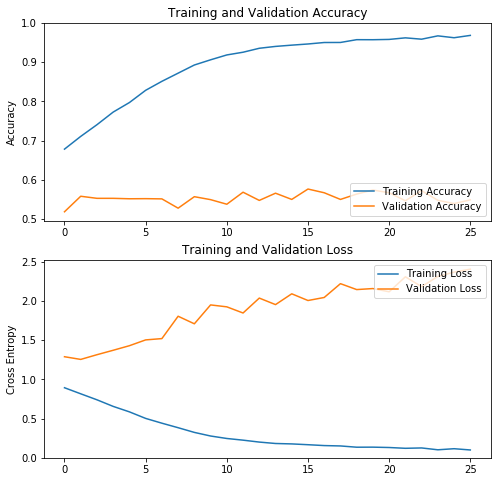

In [66]:
# # #run and train model
monitor_index = 'val_acc'
model_name = 'alexnet_'+ monitor_index

history = run_model(model, model_name, 50, [x_train, y_train_cat], [x_public_test, y_public_test_cat], 100, monitor_index)
save_model(model,model_name, working_dir)
draw_graphs(history)

# test the model on sefies

In [5]:
model = Model(working_dir + 'checkpoints/', 'newData_vggFace_finetune_val_loss_0.98_64.4.json','newData_vggFace_finetune_val_loss_0.98_64.4.h5')
model_best = model.model

D:/Mandy/emotion-recognition-transferlearning/checkpoints/newData_vggFace_finetune_val_loss_0.98_64.4.json
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## plot confusion matrix on validation images

In [ ]:
predictions = model_best.predict(valid_new_x)

y_pred = [np.argmax(probas) for probas in predictions]
    
# compute confusion matrix
cnf_matrix = confusion_matrix(valid_label_array, y_pred)
np.set_printoptions(precision=2)

<Figure size 432x288 with 0 Axes>

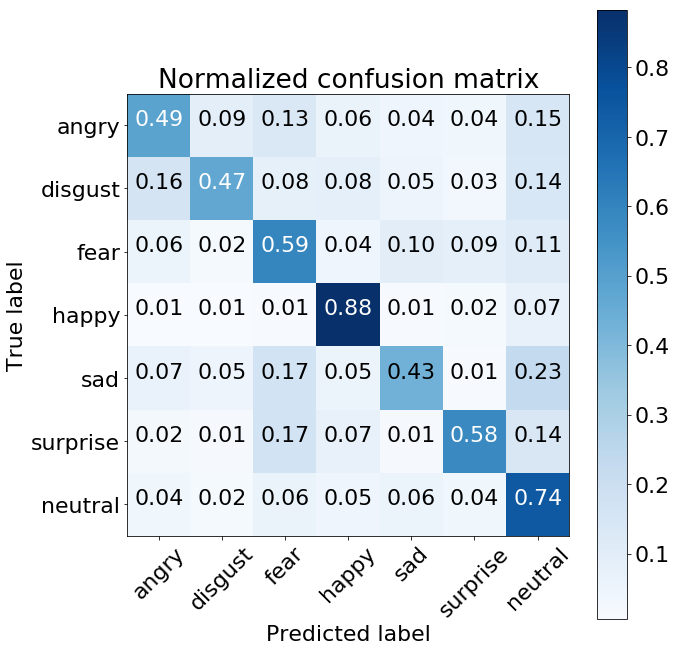

In [27]:
# plot normalized confusion matrix
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

plt.rc('font', **font)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=emotion_dict.values(), title='Normalized confusion matrix')
plt.show()

## test performance on test images

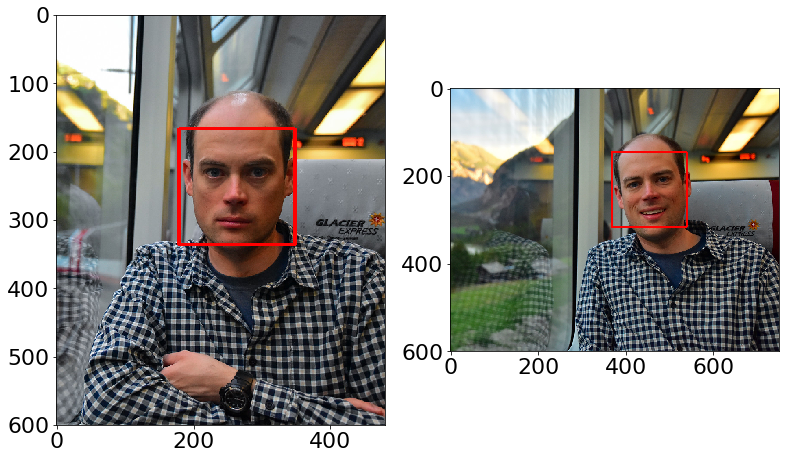

In [30]:
test_dir = 'data/test_pics'
test_list = sorted(glob.glob(os.path.join(working_dir,test_dir,'*')))
detector = FaceDetector(working_dir + "haarcascade_frontalface_default.xml")
# the width and height of the output face; could be set to (48,48)
resized_shape = (224,224)
image_show_length = 600
#show the images
show_image_num = 2 # how many images to show

plt.figure(figsize = (20, 8))
for image_id, image_path in enumerate(test_list[:show_image_num]):
    image = load_test_image(image_path,image_show_length)
    faces_coord = detector.detect(image, True)
    image = add_bounding_box_text(image,faces_coord,'')
    plt.subplot(1, len(test_list)+1, image_id+1)
    plt.imshow(image)
plt.show()

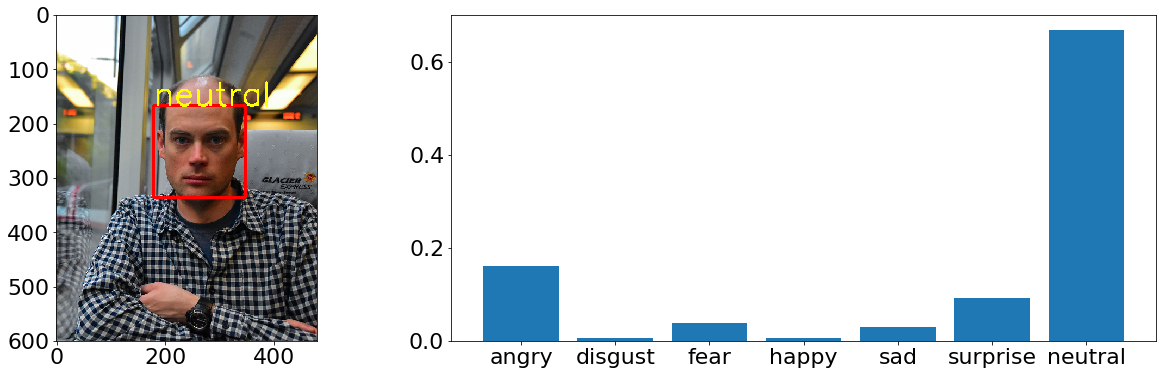

In [43]:
test_image = load_test_image(test_list[0],600)
plot_single_image_prediction(test_image, detector, resized_shape, model_best,emotion_dict)

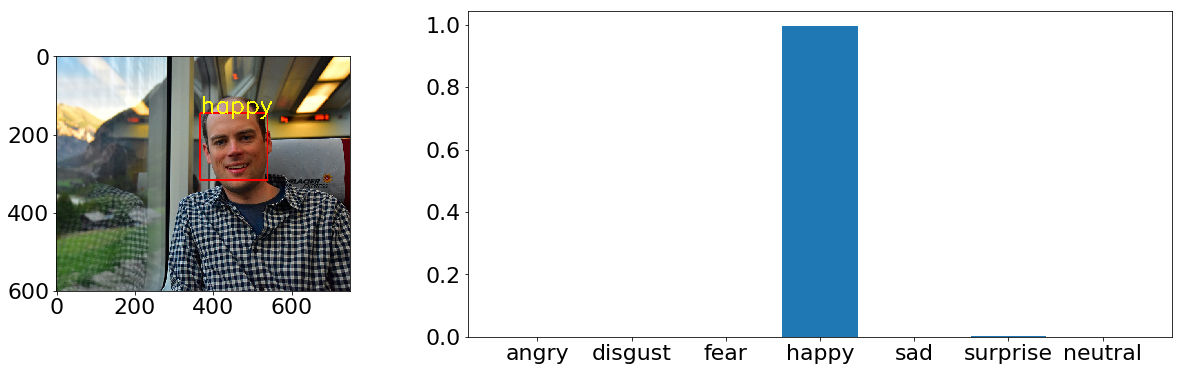

In [44]:
test_image = load_test_image(test_list[1],600)
plot_single_image_prediction(test_image, detector, resized_shape, model_best,emotion_dict)